<a href="https://colab.research.google.com/github/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Item_based_Collaborative_Recommender_System_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Loading MovieLens dataset

In [50]:
df_tags = pd.read_csv("ml-20m/tags.csv")
df_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [51]:
len(df_tags), max(df_tags['movieId']),min(df_tags['movieId'])

(465564, 131258, 1)

In [52]:
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [53]:
len(df_ratings), max(df_ratings['rating']),min(df_ratings['rating'])

(20000263, 5.0, 0.5)

In [54]:
df_movies = pd.read_csv("ml-20m/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Merging required datasets

In [55]:
merged_df = pd.merge(df_ratings, df_movies, how='inner', on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


In [56]:
len(merged_df)

20000263

Example of a multiple rating scenario by a specific movie:

In [57]:
merged_df[(merged_df['title'] == 'Chasing Amy (1997)') ]

,userId,movieId,rating,timestamp,title,genres
11411443,21,1639,3.0,992190290,Chasing Amy (1997),Comedy|Drama|Romance
11411444,23,1639,3.0,914457720,Chasing Amy (1997),Comedy|Drama|Romance
11411445,24,1639,5.0,994230323,Chasing Amy (1997),Comedy|Drama|Romance
11411446,33,1639,5.0,966285369,Chasing Amy (1997),Comedy|Drama|Romance
11411447,40,1639,1.0,941626558,Chasing Amy (1997),Comedy|Drama|Romance
...,...,...,...,...,...,...
11425371,138444,1639,3.0,940033447,Chasing Amy (1997),Comedy|Drama|Romance
11425372,138449,1639,4.0,996910792,Chasing Amy (1997),Comedy|Drama|Romance
11425373,138459,1639,3.5,1249438614,Chasing Amy (1997),Comedy|Drama|Romance
11425374,138467,1639,4.0,951848803,Chasing Amy (1997),Comedy|Drama|Romance


In [58]:
refined_dataset = merged_df.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,userId,title,rating
0,1,2001: A Space Odyssey (1968),3.5
1,1,28 Days Later (2002),3.5
2,1,"7th Voyage of Sinbad, The (1958)",4.0
3,1,"Adventures of Baron Munchausen, The (1988)",4.0
4,1,Alien (1979),4.0


In [59]:
refined_dataset[(refined_dataset['title'] == 'Chasing Amy (1997)') ]

,userId,title,rating
2162,21,Chasing Amy (1997),3.0
2448,23,Chasing Amy (1997),3.0
2624,24,Chasing Amy (1997),5.0
3864,33,Chasing Amy (1997),5.0
4341,40,Chasing Amy (1997),1.0
...,...,...,...
19993616,138444,Chasing Amy (1997),3.0
19993966,138449,Chasing Amy (1997),4.0
19995614,138459,Chasing Amy (1997),3.5
19996395,138467,Chasing Amy (1997),4.0


## Exploratory data analysis

In [60]:
num_users = len(refined_dataset['userId'].value_counts())
print(num_users)
num_items = len(refined_dataset['title'].value_counts())
print(num_items)

138493
26729


In [61]:
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 138493
Unique number of movies in the dataset: 26729


In [62]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.50,239116
0.75,2
1.00,680722
1.25,5
1.50,279238
1.75,6
2.00,1430960
2.25,13
2.50,883351


Text(0, 0.5, 'number of ratings')

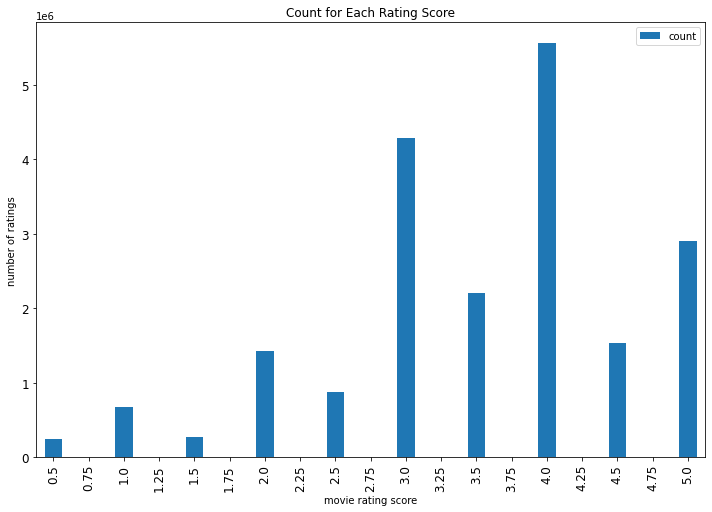

In [63]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [64]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

3681779458

In [65]:
# append counts of zero rating to df_ratings_cnt
rating_count_df = rating_count_df.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
rating_count_df

,count
0.00,3681779458
0.50,239116
0.75,2
1.00,680722
1.25,5
1.50,279238
1.75,6
2.00,1430960
2.25,13
2.50,883351
